Apache Server log analysis
=========

#### Required python module
   1. [apachelog](https://pypi.python.org/pypi/apachelog), for log parsing
   2. [pandas](https://pypi.python.org/pypi/pandas), for log manupulaiton and analysis
   3. [matplotlib](https://pypi.python.org/pypi/matplotlib) for visualization

Log format (I found at [this SO answer](http://stackoverflow.com/questions/9234699/understanding-apache-access-log)) and a short description of every element:

**format** = '%V %h  %l %u %t \"%r\" %>s %b \"%i\" \"%{User-Agent}i\" %T'
    
    %V 	     - The server name
    %h          - remote host (ie the client IP)
    %l          - identity of the user determined by identd (not usually used 
                  since not reliable)
    %u          - user name determined by HTTP authentication
    %t          - time the server finished processing the request.
    %r          - request line from the client. ("GET / HTTP/1.0")
    %>s         - status code sent from the server to the client (200, 404 etc.)
    %b          - size of the response to the client (in bytes)
    \"%i\"      - Referer is the URL of the page from which this request 
                  was initiated). if no URL is present then "-".
    User-agent  - browser identification string
    %T 	     - The time taken to serve the request, in seconds.
    

In [1]:
import apachelog, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import legend
%matplotlib inline

Set the format:

In [2]:
logFormat = r'%V %h %l %u %t \"%r\" %>s %b \"%i\" \"%{User-Agent}i\" %T'

In [3]:
# create parser
p = apachelog.parser(logFormat)

Sample string:
        
        abc.net 66.249.79.135 - - [17/Aug/2017:06:32:25 +0000] "GET /popular-social-networking-sites/ HTTP/1.1" 301 178 "-" "Mozilla/5.0 (compatible; Googlebot/2.1; +http://www.google.com/bot.html)" 0


In [4]:
sample_log = 'abc.net 150.70.173.21 - - [17/Aug/2017:06:25:24 +0000] "GET / HTTP/1.1" 301 178 "-" "Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.2 (KHTML, like Gecko) Chrome/22.0.1216.0 Safari/537.2" 0'

In [5]:
data = p.parse(sample_log)

In [6]:
data

{'%>s': '301',
 '%T': '0',
 '%V': 'abc.net',
 '%b': '178',
 '%h': '150.70.173.21',
 '%i': '-',
 '%l': '-',
 '%r': 'GET / HTTP/1.1',
 '%t': '[17/Aug/2017:06:25:24 +0000]',
 '%u': '-',
 '%{User-Agent}i': 'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.2 (KHTML, like Gecko) Chrome/22.0.1216.0 Safari/537.2'}

## Load Log Data

In [7]:
log = open('apache_log').readlines()

In [8]:
# chacking type
type(log)

list

In [9]:
# print 1st log
log[1]

'www.oceanographers.ru 109.165.31.156 - - [16/Mar/2013:08:00:25 +0400] "GET /templates/ja_procyon/css/template_css.css HTTP/1.0" 200 10532 "http://www.oceanographers.ru/index.php?option=com_content&task=section&id=30&Itemid=265" "Mozilla/5.0 (Windows NT 6.1; rv:19.0) Gecko/20100101 Firefox/19.0" 0\n'

Parse every line of it and create a list of dictionaries:

In [10]:
log_list = []
for line in log:
       try:
          data = p.parse(line)
#           print("Data is {0}".format(data))
       except:
          sys.stderr.write("Unable to parse %s" % line)
       # tweaking date-time format compatible for pandas as "Date Time "
       data['%t'] = data['%t'][1:12]+' '+data['%t'][13:21] 
#        print("Date is {0}".format(data['%t'][1:12]))
#        print("Time(HH:MM:SS) is {0}".format(data['%t'][13:21]))
#        print("Milisecond is {0}".format(data['%t'][22:27]))

       log_list.append(data) # list of dictionary


### Create and tune Data Frame

In [11]:
# convert list of dictionary to DataFrame
log_df = pd.DataFrame(log_list)

In [12]:
log_df.head()

,%>s,%T,%V,%b,%h,%i,%l,%r,%t,%u,%{User-Agent}i
0,200,0,www.oceanographers.ru,26126,109.165.31.156,-,-,GET /index.php?option=com_content&task=section...,16/Mar/2013 08:00:25,-,Mozilla/5.0 (Windows NT 6.1; rv:19.0) Gecko/20...
1,200,0,www.oceanographers.ru,10532,109.165.31.156,http://www.oceanographers.ru/index.php?option=...,-,GET /templates/ja_procyon/css/template_css.css...,16/Mar/2013 08:00:25,-,Mozilla/5.0 (Windows NT 6.1; rv:19.0) Gecko/20...
2,200,0,www.oceanographers.ru,1853,109.165.31.156,http://www.oceanographers.ru/index.php?option=...,-,GET /templates/ja_procyon/switcher.js HTTP/1.0,16/Mar/2013 08:00:25,-,Mozilla/5.0 (Windows NT 6.1; rv:19.0) Gecko/20...
3,200,0,www.oceanographers.ru,37153,109.165.31.156,http://www.oceanographers.ru/index.php?option=...,-,GET /includes/js/overlib_mini.js HTTP/1.0,16/Mar/2013 08:00:25,-,Mozilla/5.0 (Windows NT 6.1; rv:19.0) Gecko/20...
4,200,0,www.oceanographers.ru,3978,109.165.31.156,http://www.oceanographers.ru/index.php?option=...,-,GET /modules/ja_transmenu/transmenuh.css HTTP/1.0,16/Mar/2013 08:00:25,-,Mozilla/5.0 (Windows NT 6.1; rv:19.0) Gecko/20...


#### Deleting few unnecessary column from Dataframe
 - Useless Column
  - %T %V %i, %l, %u

In [13]:
del log_df['%T']; del log_df['%V']; del log_df['%i']; del log_df['%l']; del log_df['%u'];

#### Renaming column to meaningful name

In [14]:
log_df = log_df.rename(columns={'%>s': 'StatusCode', '%b':'Bytes', 
                        '%h':'IP', '%r':'Method', '%t': 'TimeStamp',
                               '%{User-Agent}i':'User-Agent'})

First five rows of resulting Data Frame:

In [15]:
log_df.head()

,StatusCode,Bytes,IP,Method,TimeStamp,User-Agent
0,200,26126,109.165.31.156,GET /index.php?option=com_content&task=section...,16/Mar/2013 08:00:25,Mozilla/5.0 (Windows NT 6.1; rv:19.0) Gecko/20...
1,200,10532,109.165.31.156,GET /templates/ja_procyon/css/template_css.css...,16/Mar/2013 08:00:25,Mozilla/5.0 (Windows NT 6.1; rv:19.0) Gecko/20...
2,200,1853,109.165.31.156,GET /templates/ja_procyon/switcher.js HTTP/1.0,16/Mar/2013 08:00:25,Mozilla/5.0 (Windows NT 6.1; rv:19.0) Gecko/20...
3,200,37153,109.165.31.156,GET /includes/js/overlib_mini.js HTTP/1.0,16/Mar/2013 08:00:25,Mozilla/5.0 (Windows NT 6.1; rv:19.0) Gecko/20...
4,200,3978,109.165.31.156,GET /modules/ja_transmenu/transmenuh.css HTTP/1.0,16/Mar/2013 08:00:25,Mozilla/5.0 (Windows NT 6.1; rv:19.0) Gecko/20...


Convert TimeStamp column to datetime format

In [16]:
log_df['TimeStamp'] = pd.to_datetime(log_df['TimeStamp'])

In [17]:
log_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6634 entries, 0 to 6633
Data columns (total 6 columns):
StatusCode    6634 non-null object
Bytes         6634 non-null object
IP            6634 non-null object
Method        6634 non-null object
TimeStamp     6634 non-null datetime64[ns]
User-Agent    6634 non-null object
dtypes: datetime64[ns](1), object(5)
memory usage: 311.0+ KB


In [18]:
log_df.head()

,StatusCode,Bytes,IP,Method,TimeStamp,User-Agent
0,200,26126,109.165.31.156,GET /index.php?option=com_content&task=section...,2013-03-16 08:00:25,Mozilla/5.0 (Windows NT 6.1; rv:19.0) Gecko/20...
1,200,10532,109.165.31.156,GET /templates/ja_procyon/css/template_css.css...,2013-03-16 08:00:25,Mozilla/5.0 (Windows NT 6.1; rv:19.0) Gecko/20...
2,200,1853,109.165.31.156,GET /templates/ja_procyon/switcher.js HTTP/1.0,2013-03-16 08:00:25,Mozilla/5.0 (Windows NT 6.1; rv:19.0) Gecko/20...
3,200,37153,109.165.31.156,GET /includes/js/overlib_mini.js HTTP/1.0,2013-03-16 08:00:25,Mozilla/5.0 (Windows NT 6.1; rv:19.0) Gecko/20...
4,200,3978,109.165.31.156,GET /modules/ja_transmenu/transmenuh.css HTTP/1.0,2013-03-16 08:00:25,Mozilla/5.0 (Windows NT 6.1; rv:19.0) Gecko/20...


Make `TimeStamp` column as index of DataFrame (*pop* will drop original *TimeStamp* column): 

In [19]:
log_df.index = log_df.pop('TimeStamp')

In [20]:
log_df.head(2)

,StatusCode,Bytes,IP,Method,User-Agent
TimeStamp,,,,,
2013-03-16 08:00:25,200,26126,109.165.31.156,GET /index.php?option=com_content&task=section...,Mozilla/5.0 (Windows NT 6.1; rv:19.0) Gecko/20...
2013-03-16 08:00:25,200,10532,109.165.31.156,GET /templates/ja_procyon/css/template_css.css...,Mozilla/5.0 (Windows NT 6.1; rv:19.0) Gecko/20...


Convert *Status* column from stirng to int.

In [21]:
log_df['StatusCode'] = log_df['StatusCode'].astype('int')

100 rows in the *Bytes* column contain '-' string, so we can't convert them with *astype*:

In [22]:
log_df[log_df['Bytes']=='-']

,StatusCode,Bytes,IP,Method,User-Agent
TimeStamp,,,,,
2013-03-16 08:19:41,304,-,178.154.206.250,GET /images/stories/researchers/laplace.jpg HT...,Mozilla/5.0 (compatible; YandexImages/3.0; +ht...
2013-03-16 08:33:14,304,-,178.154.206.250,GET /images/stories/researchers/treshnikov.jpg...,Mozilla/5.0 (compatible; YandexImages/3.0; +ht...
2013-03-16 08:42:43,304,-,178.154.206.250,GET /mypict/moc2.png HTTP/1.0,Mozilla/5.0 (compatible; YandexImages/3.0; +ht...
2013-03-16 08:47:04,302,-,176.8.91.244,POST /podcast/wp-comments-post.php HTTP/1.0,Mozilla/5.0 (Windows NT 6.1; rv:14.0) Gecko/20...
2013-03-16 09:14:31,304,-,178.154.206.250,GET /mypict/liza2_4_converted.jpg HTTP/1.0,Mozilla/5.0 (compatible; YandexImages/3.0; +ht...
2013-03-16 09:40:22,301,-,72.14.199.215,GET /podcast/?feed=rss HTTP/1.0,Feedfetcher-Google; (+http://www.google.com/fe...
2013-03-16 10:44:04,304,-,46.4.95.2,GET /podcast/?feed=rss HTTP/1.0,Mozilla/4.0 (compatible; MSIE 7.0; Windows NT ...
2013-03-16 10:47:18,301,-,72.14.199.215,GET /podcast/?feed=rss HTTP/1.0,Feedfetcher-Google; (+http://www.google.com/fe...
2013-03-16 11:27:40,302,-,78.30.212.183,POST /podcast/wp-comments-post.php HTTP/1.0,Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.1...


Applying a custom function to this column, that will convert all dashes('-') to NaN, and the rest to floats and then converting from bytes to megabytes:

In [23]:
def dashToNan(x):
    if x == '-':
        x = np.nan
    else:
        x = float(x)/1048576.0
    return x

In [24]:
log_df['Bytes'] = log_df['Bytes'].apply(dashToNan)

## Traffic analysis

In [25]:
# Maximum respnse size
log_df['Bytes'].max()

21.365700721740723

Largest size of response is 21.37Mb.

In [26]:
# Minimum response size
log_df['Bytes'].min()

2.47955322265625e-05

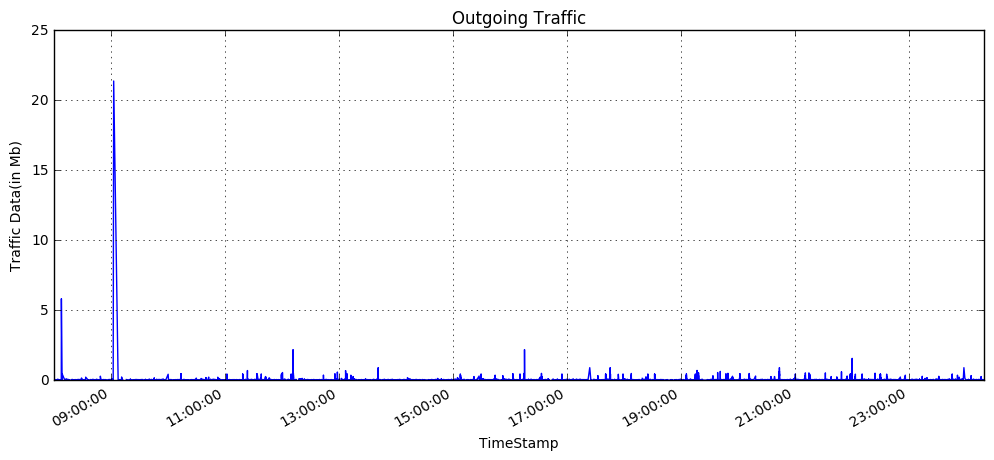

In [27]:
plt.figure(figsize=(12,5))
log_df['Bytes'].plot(grid=True)
plt.ylabel("Traffic Data(in Mb)")
plt.title("Outgoing Traffic")
plt.show()

### Visualizing no. of visit for every 10 minute interval
    How many people visited site in every 10 minute?

Now, resample the series of variable ***Bytes*** with 10 minute intervals, and calculate number of requests during every 10 minute time span. 

Actually, in this case it doesn't matter what variable use, these numbers will indicate just how many times information from the website was requested. Another variable e.g. ***IP*** instead of ***Bytes*** can be used to visualize the same. 

*See next two visualization - 1st using* ***Bytes*** *and 2nd using* ***IP***

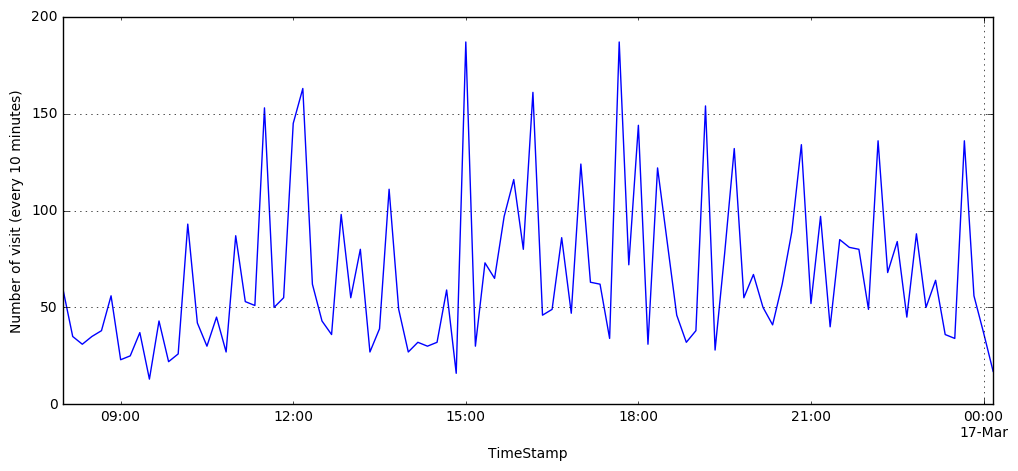

In [28]:
plt.figure(figsize=(12,5))
every_10minutely_df = log_df.Bytes.resample('10min').count()
every_10minutely_df.plot(grid=True)
plt.ylabel("Number of visit (every 10 minutes)")
plt.show()

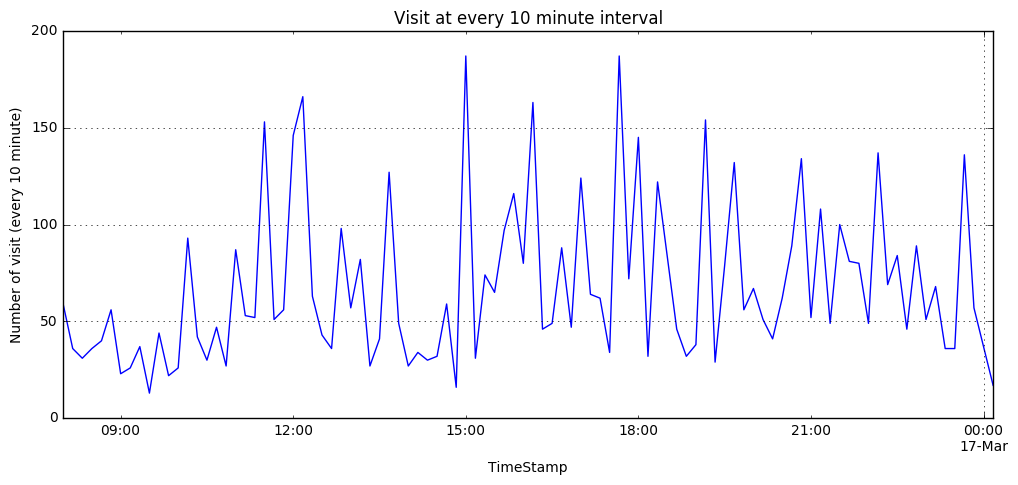

In [29]:
plt.figure(figsize=(12,5))
every_10minutely_Series = log_df.IP.resample('10min').count()
every_10minutely_Series.plot(grid=True)
plt.title("Visit at every 10 minute interval")
plt.ylabel("Number of visit (every 10 minute)")
plt.show()

Calculating the sum of the traffic(response size) for every time span:

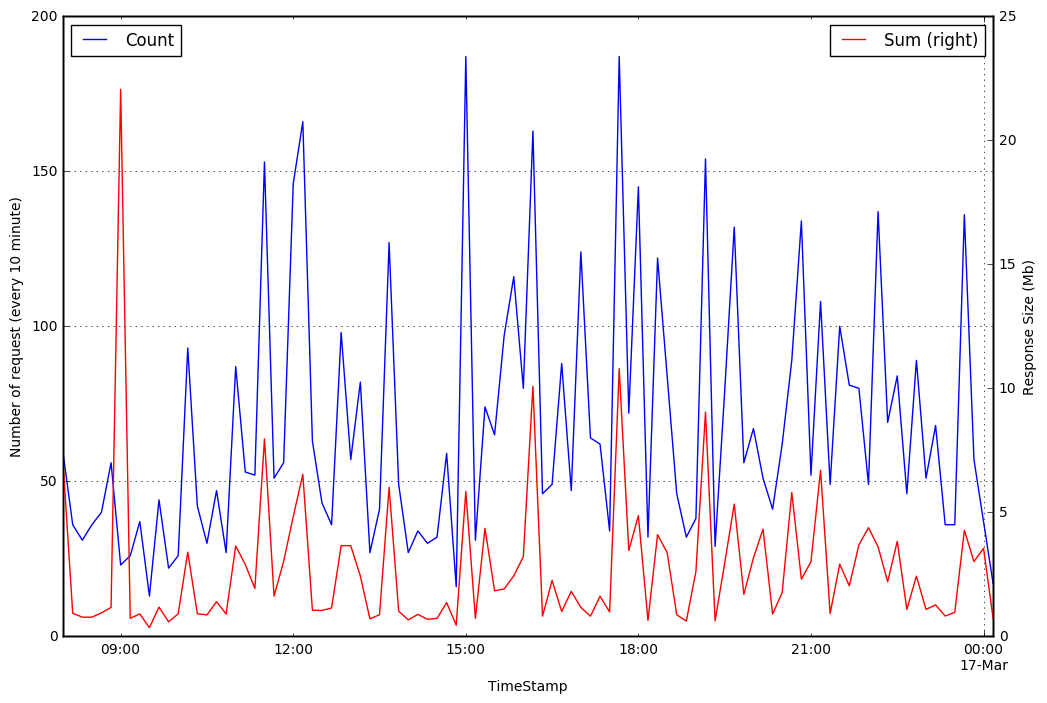

In [30]:
plt.figure(figsize=(12,8))

# Number of request every 10 minutes
log_10minutely_count_Series = log_df['IP'].resample('10t').count()
log_10minutely_count_Series.name="Count"
ax1 = log_10minutely_count_Series.plot(color='blue', grid=True, legend=False)
ax1.set_ylabel("Number of request (every 10 minute)")
plt.legend(loc='upper left')


# Sum of response size every each 10 minute
ax2 = ax1.twinx()
log_10minutely_sum_Series = log_df['Bytes'].resample('10t').sum()
log_10minutely_sum_Series.name = 'Sum'
ax2 = log_10minutely_sum_Series.plot(color='r',grid=True, legend=True, 
                                     secondary_y=True)
ax2.set_ylabel('Response Size (Mb)')
# plt.legend(loc='upper right')
plt.show()
         

Take a look at `amount(response size)` of traffic for a day.

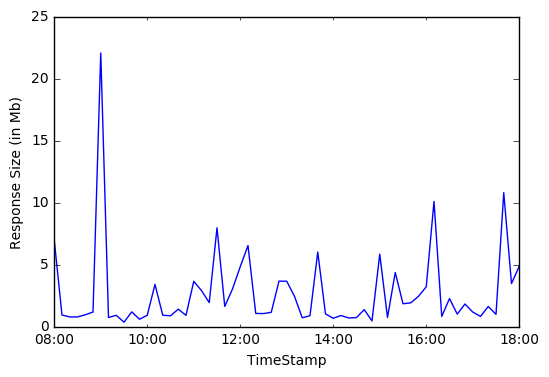

In [31]:
ax = log_10minutely_sum_Series['2013-03-16 6:00':'2013-03-16 18:00'].plot()
ax.set_ylabel('Response Size (in Mb)')
plt.show()

There is traffic very high spike in morning around  9:00 and this spike in traffic is highest for the day.

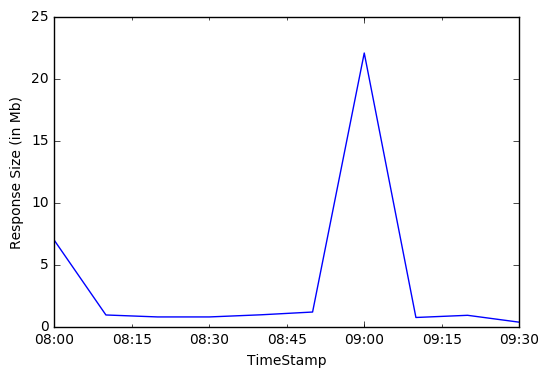

In [32]:
# get traffic from morning till 9:30
ax = log_10minutely_sum_Series[:'2013-03-16 9:30'].plot() 
ax.set_ylabel('Response Size (in Mb)')
plt.show()

It seems that highes traffic spike was at 9:00.
Choose all requests with the size of the response larger than 20 Mb.

In [33]:
log_df[log_df['Bytes'] > 20]

,StatusCode,Bytes,IP,Method,User-Agent
TimeStamp,,,,,
2013-03-16 09:02:59,200,21.365701,77.50.248.20,GET /books/Bondarenko.pdf HTTP/1.0,Download Master


It was download of **`.pdf`** file that couses peak in outgoing trafic at 2013-03-16 09:02:59.

#### Visualize server's response size
    Since 21Mb is the largest response size. Visualize response with size <21Mb.
    
    The histogram of response sizes (less than 20 Mb) looks like this:

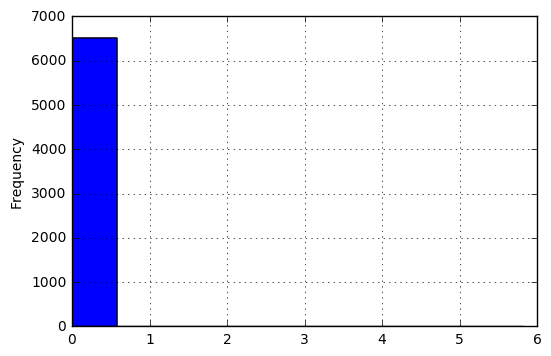

In [34]:
log_df_f = log_df[log_df['Bytes']<20]
log_df_f.Bytes.plot(kind='hist', bins=10, legend=False, grid=True)
plt.show()

### Average response size

In [35]:
log_df.Bytes.mean()

0.040861973384487035

So,  average size of file is 0.04Mb. Plotting histogram with size <0.04Mb.

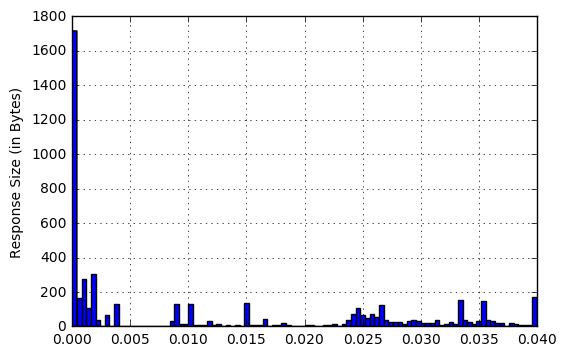

In [36]:
cc = log_df[log_df['Bytes']<0.04]
cc.Bytes.hist(bins=100)
plt.ylabel('Response Size (in Bytes)')
plt.show()

Analyzing traffic between response size - 0.025 and 0.03Mb and find the response with highest response between these two value:

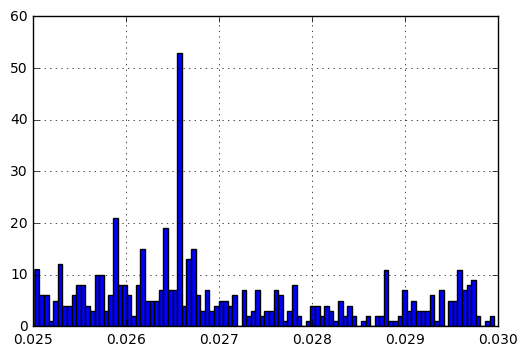

In [37]:
log_1df = log_df[(log_df['Bytes']<0.03)&(log_df['Bytes']> 0.025)]
log_1df.Bytes.hist(bins=100)
plt.show()

Locating the largest file, which is of 0.026Mb < `size` < 0.027Mb. Now, locate the size of the file more precisely, and find out its name:

In [38]:
dd = log_1df[(log_1df['Bytes']>0.026)&(log_1df['Bytes']<0.027)]
print(dd.max())

StatusCode                                                  200
Bytes                                                 0.0269947
IP                                                 95.46.123.25
Method                       GET /mypict/chloriso2.jpg HTTP/1.0
User-Agent    Opera/9.80 (Windows NT 6.2; WOW64; MRA 8.0 (bu...
dtype: object


Oh! It is an image.

### Analyzing Server status codes

Find out how different server responses are distributed throughout whole day.  

Creating several variables with time series of *StatusCode* values, each containing only a time series with one particular value.

In [39]:
t_span = '2H'
# resampling data with 2 hour interval
df_404 = log_df['StatusCode'][log_df['StatusCode'] == 404].resample(t_span).count()
df_403 = log_df['StatusCode'][log_df['StatusCode'] == 403].resample(t_span).count()
df_301 = log_df['StatusCode'][log_df['StatusCode'] == 301].resample(t_span).count()
df_304 = log_df['StatusCode'][log_df['StatusCode'] == 304].resample(t_span).count()
df_200 = log_df['StatusCode'][log_df['StatusCode'] == 200].resample(t_span).count()

In [40]:
# creating single dataFrame with different status code
status_df = pd.DataFrame({'Not Found':df_404, 'Forbidden':df_403, 'Moved Permanently':df_301, 'Not Modified':df_304, 'OK':df_200,})

In [41]:
status_df.head()

,Forbidden,Moved Permanently,Not Found,Not Modified,OK
TimeStamp,,,,,
2013-03-16 08:00:00,22,17,3,4.0,375
2013-03-16 10:00:00,26,76,2,2.0,607
2013-03-16 12:00:00,45,83,2,23.0,780
2013-03-16 14:00:00,29,34,4,2.0,699
2013-03-16 16:00:00,27,94,5,3.0,886


#### Visualizing different Status Code distribution

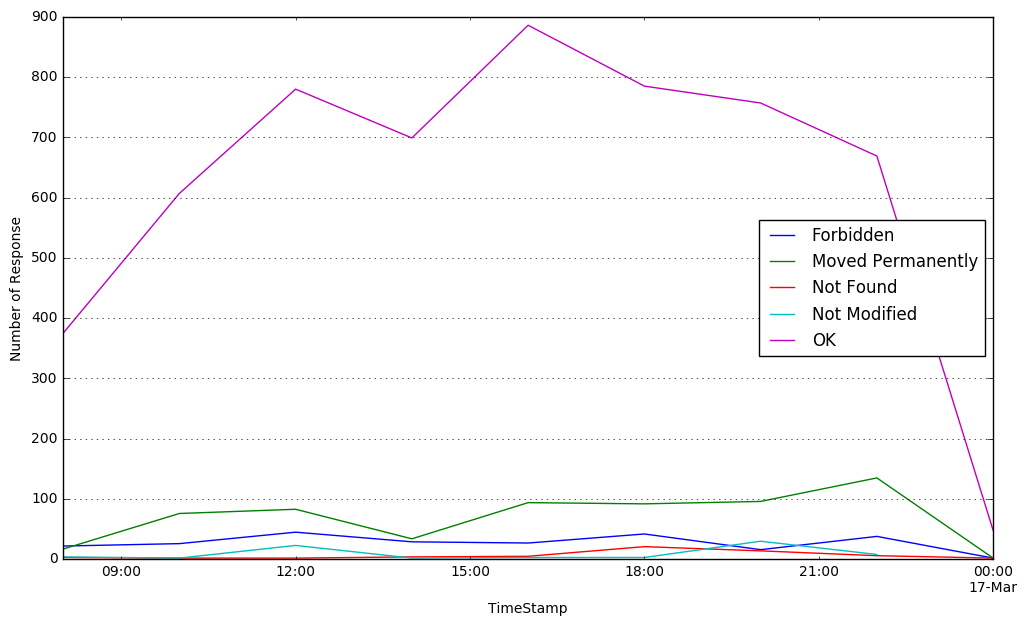

In [42]:
status_df.plot(figsize=(12,7), grid=True)
plt.ylabel("Number of Response")
plt.show()

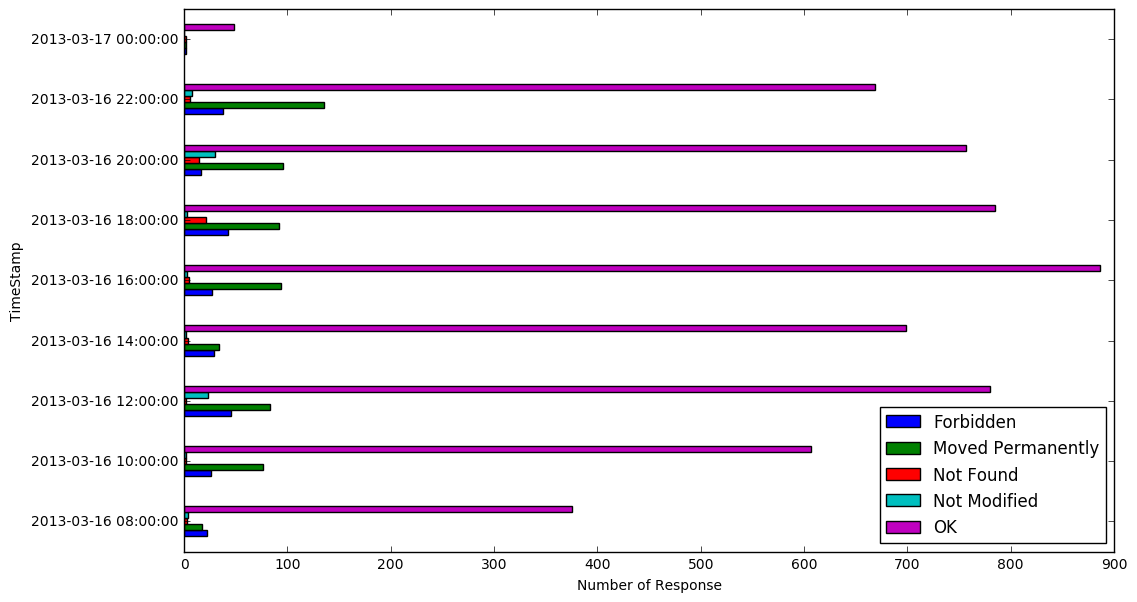

In [43]:
status_df.plot(kind='barh',figsize=(12, 7), legend=True)
plt.xlabel("Number of Response")
plt.show()

Visualizing previous result using stacked bar plot.

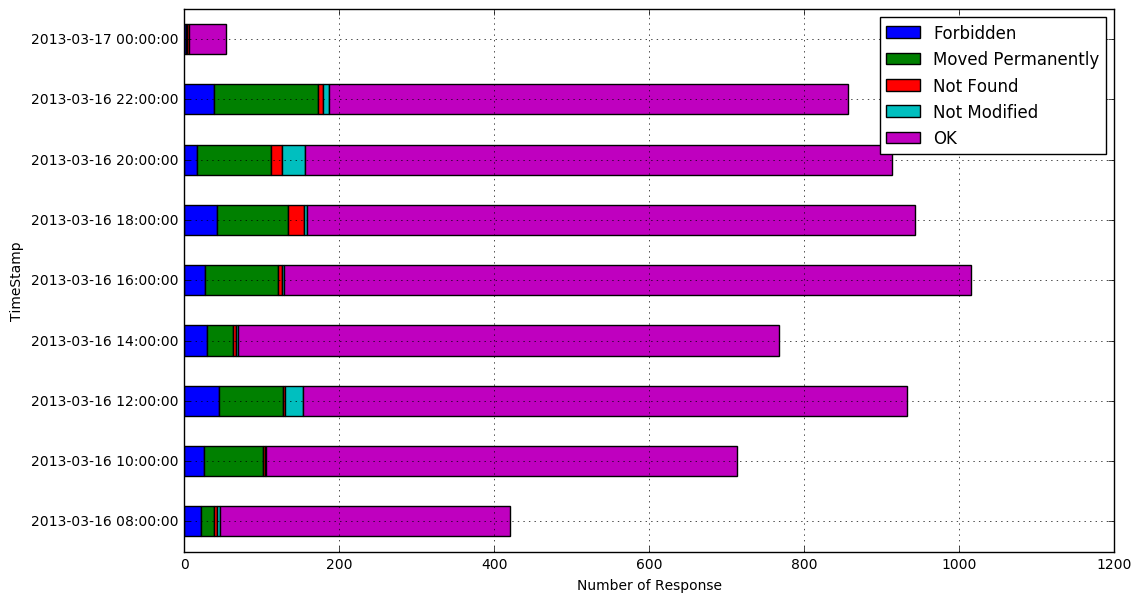

In [44]:
status_df.plot(kind='barh', stacked=True, legend=True, grid=True, figsize=(12,7))
plt.xlabel("Number of Response")
plt.show()

Visualizing only **Error** and **Redirection** status codes as a stacked plot (no *OK* status code):

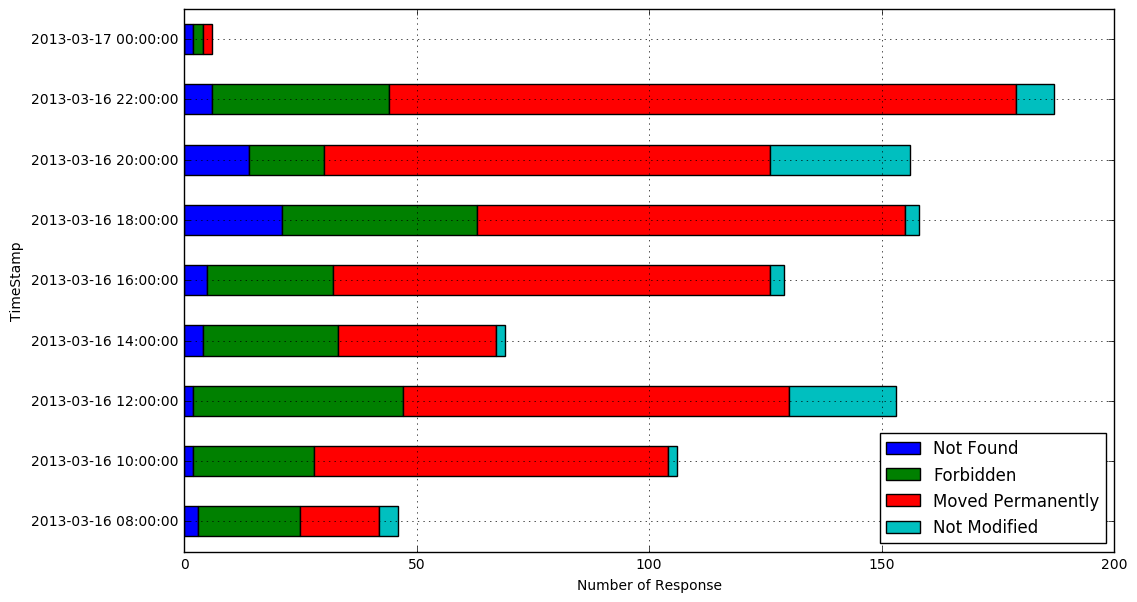

In [45]:
status_df[['Not Found','Forbidden','Moved Permanently','Not Modified']
         ].plot(kind='barh', stacked=True, legend=True,grid=True, figsize=(12, 7))
plt.xlabel("Number of Response")
plt.show()

But there is a better way to receive statistics about different groups of values. Here grouping data by **StatusCode**:

In [46]:
grouped_status = log_df.groupby('StatusCode')

Here Data is now rearranged into several groups, each corresponding to a certain value of **StatusCode**.

See, first two values of every group of **StatusCode**:

In [47]:
grouped_status.head(2)

,StatusCode,Bytes,IP,Method,User-Agent
TimeStamp,,,,,
2013-03-16 08:00:25,200,0.024916,109.165.31.156,GET /index.php?option=com_content&task=section...,Mozilla/5.0 (Windows NT 6.1; rv:19.0) Gecko/20...
2013-03-16 08:00:25,200,0.010044,109.165.31.156,GET /templates/ja_procyon/css/template_css.css...,Mozilla/5.0 (Windows NT 6.1; rv:19.0) Gecko/20...
2013-03-16 08:04:23,403,0.001054,5.79.199.116,GET /forum/download/file.php?avatar=156.gif HT...,Mozilla/5.0 (Linux; Android 4.0.3; HTC Desire ...
2013-03-16 08:04:23,403,0.001054,5.79.199.116,GET /forum/download/file.php?avatar=216.jpg HT...,Mozilla/5.0 (Linux; Android 4.0.3; HTC Desire ...
2013-03-16 08:04:25,404,0.001063,5.79.199.116,GET /apple-touch-icon-precomposed.png HTTP/1.0,Mozilla/5.0 (Linux; Android 4.0.3; HTC Desire ...
2013-03-16 08:04:26,404,0.001063,5.79.199.116,GET /apple-touch-icon.png HTTP/1.0,Mozilla/5.0 (Linux; Android 4.0.3; HTC Desire ...
2013-03-16 08:13:08,301,0.000232,38.100.21.63,GET /forum HTTP/1.0,Mozilla/4.0 (compatible; MSIE 7.0; Windows NT ...
2013-03-16 08:13:09,400,0.000999,38.100.21.63,GET /.. HTTP/1.0,Mozilla/4.0 (compatible; MSIE 7.0; Windows NT ...
2013-03-16 08:13:09,301,0.000234,38.100.21.63,GET /podcast HTTP/1.0,Mozilla/4.0 (compatible; MSIE 7.0; Windows NT ...


##### Counting the number of values in each group:

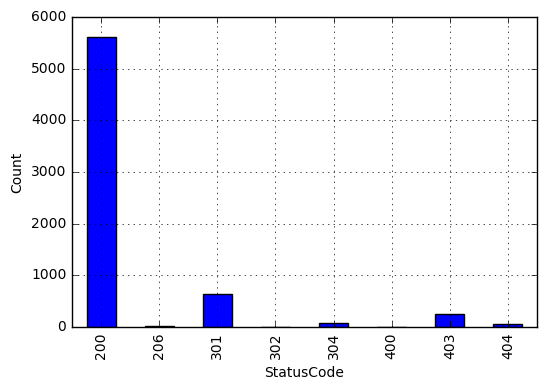

In [48]:
grouped_status.size().plot(kind='bar', grid=True)
plt.ylabel("Count")
plt.show()

##### Now, Sorting the number of values in each group by count then **Visualizing**:

In [49]:
sorted_status = log_df[['StatusCode']].groupby(['StatusCode'])['StatusCode'].count().sort_values(
ascending=False)
sorted_status.head()

StatusCode
200    5606
301     629
403     247
304      75
404      59
Name: StatusCode, dtype: int64

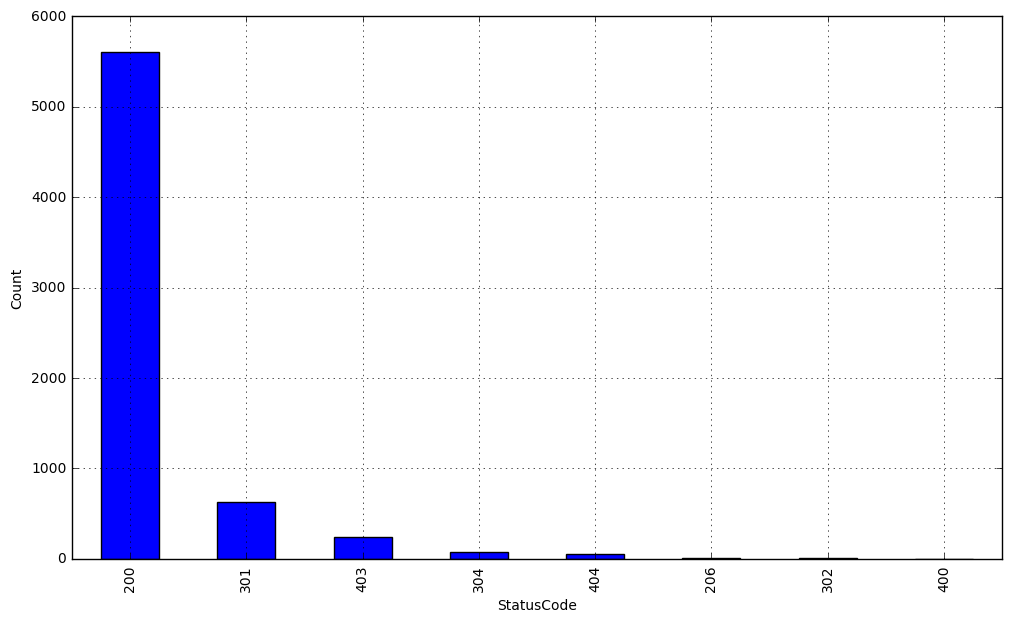

In [50]:
sorted_status.plot(kind='bar', grid=True,figsize=(12,7))
plt.ylabel("Count")
plt.show()

Look at individual groups (301 & 200) by resampling at 30 minute interval:

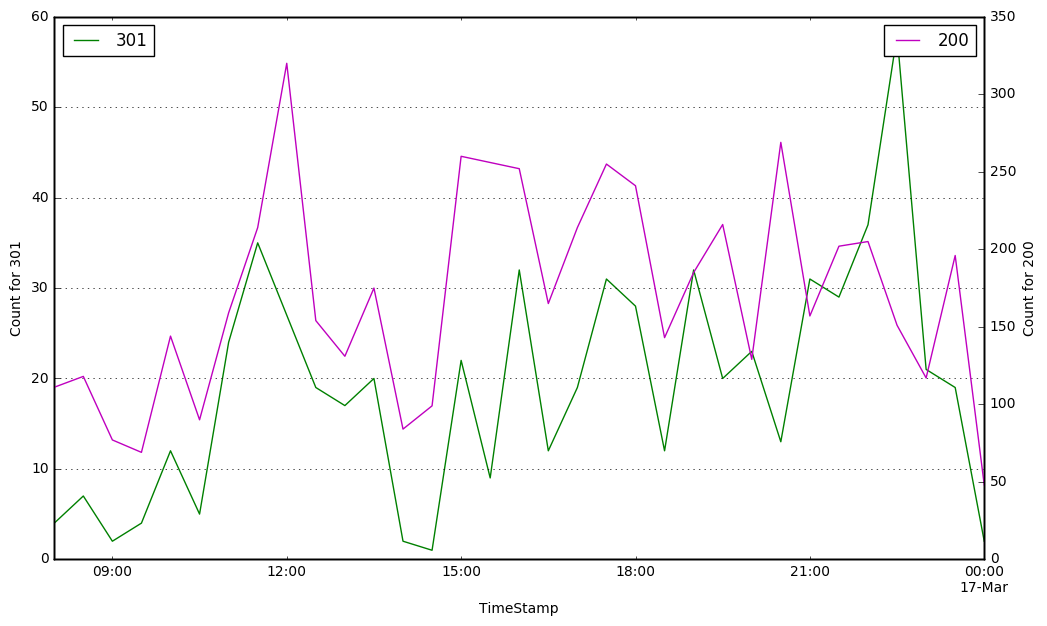

In [51]:
t_span = '30min'

plt.figure(figsize=(12,7))


ax1 = grouped_status.get_group(301)['StatusCode'].resample(t_span).count().plot(color='g', label='301', grid=True)
plt.legend(loc="upper left")
ax1.set_ylabel("Count for 301")
ax2 = ax1.twinx()
ax2 = grouped_status.get_group(200)['StatusCode'].resample(t_span).count().plot(color='m', grid=True,secondary_y=True, label='200')
ax2.set_ylabel("Count for 200")
plt.legend()
plt.show()

### IP's Request Analysis

Group by IPs and calculate how many times each IP tried to access site: 

In [52]:
request_byIP = log_df.groupby('IP').size()
request_byIP.head(2)

IP
100.44.124.8       26
108.171.252.242    24
dtype: int64

Visualizing number of request for only top 20 IP address:

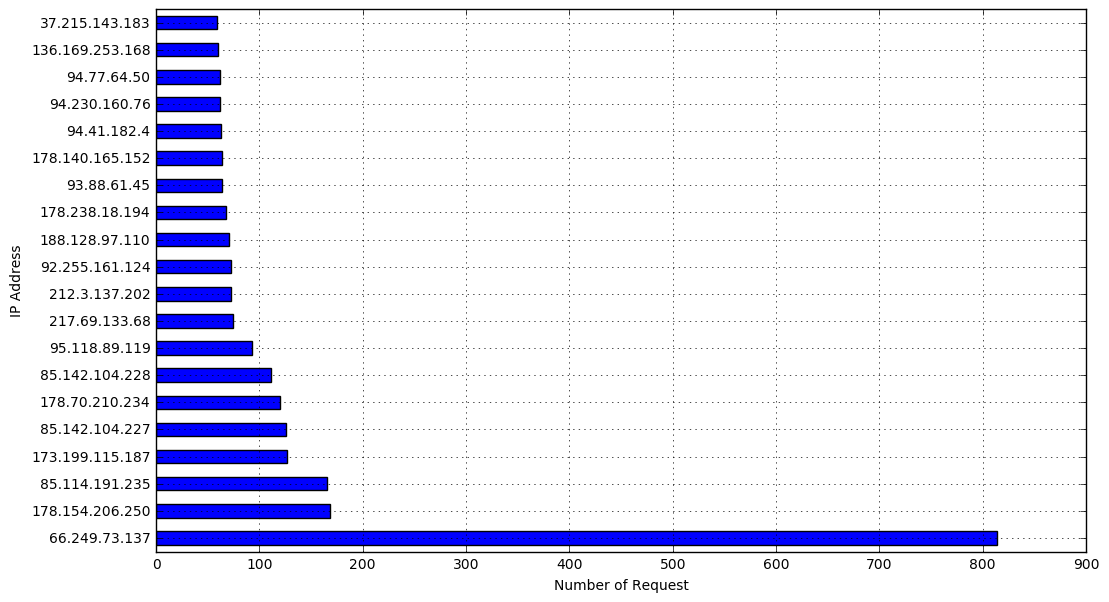

In [53]:
request_byIP.sort_values(ascending=False, inplace=True)
request_byIP.head(20).plot(kind='barh', figsize=(12,7), grid=True)
plt.xlabel("Number of Request")
plt.ylabel("IP Address")
plt.show()

Find which **IP** address tried accessing highest number of times.

In [54]:
log_df[['IP']].groupby(['IP'])['IP'].count().sort_values(ascending=False).head(1)

IP
66.249.73.137    814
Name: IP, dtype: int64

IP - `66.249.73.137` accessed server resources 814 times in whole day.

##### Visualizing distribution request by top 10 IP in terms of number of request.

In [55]:
ips_fd = pd.DataFrame({'Number of requests':request_byIP.head(10)})
# print(ips_fd[:3])
ips_fd = ips_fd.sort_values(by='Number of requests', ascending=False)
ips_fd

,Number of requests
IP,
66.249.73.137,814
178.154.206.250,168
85.114.191.235,165
173.199.115.187,127
85.142.104.227,126
178.70.210.234,120
85.142.104.228,111
95.118.89.119,93
217.69.133.68,74


This can grouped by both *IP* and *Status*:

In [56]:
ips_status = log_df.groupby(['IP', 'StatusCode']).size()

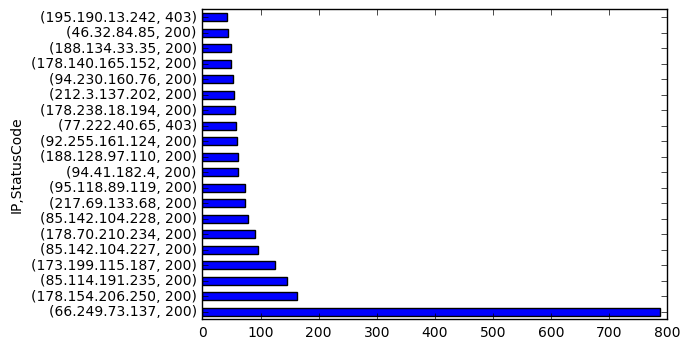

In [57]:
ips_status.sort_values(ascending=False,inplace=True)
ips_status.head(20).plot(kind='barh')
plt.show()